## 1. Mettre en oeuvre la stratification sur l'exemple de ce matin

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


datapath = 'donnees/'

# Load the data
housing = pd.read_csv(datapath + "housing.csv", thousands=',')

print(housing.shape)

housing = housing.dropna()

housing = housing[(housing["housing_median_age"]<52) & (housing["median_house_value"]<500001)]

print(housing.shape)

# Encoding la proximité en nombre

dictionnaire = {"ISLAND" : 0, "NEAR BAY" : 1, "NEAR OCEAN" :2, "<1H OCEAN" : 3, "INLAND" : 4}

housing["ocean_proximity_encoded"] = housing["ocean_proximity"].map(dictionnaire)

# Stratification : découpage avec cut en strates

housing["median_house_value_disc"] = pd.cut(housing["median_house_value"],
                                            bins=[0, 100000, 200000, 300000, 400000, 500000, np.inf],
                                            labels=["0 - 99k", "100k - 199k"  , "200k - 299k", "300k - 399k", "400k - 499k", "500k+"])

housing = housing.reset_index(drop=True)

housing.head(10)

(20640, 10)
(18379, 10)


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,ocean_proximity_encoded,median_house_value_disc
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,1,400k - 499k
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,1,300k - 399k
2,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY,1,200k - 299k
3,-122.26,37.85,50.0,1120.0,283.0,697.0,264.0,2.1250,140000.0,NEAR BAY,1,100k - 199k
4,-122.26,37.84,50.0,2239.0,455.0,990.0,419.0,1.9911,158700.0,NEAR BAY,1,100k - 199k
5,-122.27,37.85,40.0,751.0,184.0,409.0,166.0,1.3578,147500.0,NEAR BAY,1,100k - 199k
6,-122.27,37.85,42.0,1639.0,367.0,929.0,366.0,1.7135,159800.0,NEAR BAY,1,100k - 199k
7,-122.28,37.85,41.0,535.0,123.0,317.0,119.0,2.4038,107500.0,NEAR BAY,1,100k - 199k
8,-122.28,37.85,49.0,1130.0,244.0,607.0,239.0,2.4597,93800.0,NEAR BAY,1,0 - 99k
9,-122.28,37.84,50.0,2082.0,492.0,1131.0,473.0,1.6424,108900.0,NEAR BAY,1,100k - 199k


#### Stratification

In [4]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1,
                               test_size=0.4,
                               random_state=42)

for train_index, test_index in split.split(housing, housing["median_house_value_disc"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

split = StratifiedShuffleSplit(n_splits=1,
                               test_size=0.5,
                               random_state=42)

for test_index, valid_index in split.split(strat_test_set, strat_test_set["median_house_value_disc"]):
    strat_test_set = housing.loc[test_index]
    strat_valid_set = housing.loc[valid_index]

print(strat_train_set.shape)
print(strat_test_set.shape)
print(strat_valid_set.shape)

(11027, 12)
(3676, 12)
(3676, 12)


In [5]:
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [6]:
X_train = np.c_[strat_train_set[["total_rooms", "total_bedrooms", "population", "households", "median_income"]]]
y_train = np.array(strat_train_set["median_house_value"])

X_test = np.c_[strat_test_set[["total_rooms", "total_bedrooms", "population", "households", "median_income"]]]
y_test = np.array(strat_test_set["median_house_value"])

X_valid = np.c_[strat_valid_set[["total_rooms", "total_bedrooms", "population", "households", "median_income"]]]
y_valid = np.array(strat_valid_set["median_house_value"])

model = make_pipeline(StandardScaler(),
                     SGDRegressor(max_iter=1000, alpha=0.5))

model.fit(X_train, y_train)

metric1 = {'modele': 'model 1',
          'mean_absolute_error': mean_absolute_error(y_valid, model.predict(X_valid)),
          'mean_squared_error': mean_squared_error(y_valid, model.predict(X_valid)),
          'r2_score':r2_score(y_valid, model.predict(X_valid))
         }

metric1

{'modele': 'model 1',
 'mean_absolute_error': 53977.92848070078,
 'mean_squared_error': 5035744718.676088,
 'r2_score': 0.3956588433865884}

## 2. Créer une variable qualitative découpant la Californie en plusieurs zones. Pour ce faire discrétiser les variables "longitude" et "latitude" puis les concaténer.


In [7]:
housing["longitude_disc"] = pd.cut(housing["longitude"],
                               bins=[-126, -124, -122, -120, -118, -116, -114, -112],
                               labels=[1, 2, 3, 4, 5, 6, 7])

housing["latitude_disc"] = pd.cut(housing["latitude"],
                               bins=[32, 34, 36, 38, 40, 42],
                               labels=[1, 2, 3, 4, 5])

housing["location"] = housing["longitude_disc"].astype(str)+","+housing["latitude_disc"].astype(str)

housing["location"].value_counts()


5,1    3423
4,2    3313
4,1    2337
3,3    1985
2,3    1952
3,4    1632
5,2    1232
4,3     839
2,4     811
3,2     284
2,5     218
6,1     133
1,5     107
3,5      64
4,4      33
6,2      13
5,3       3
Name: location, dtype: int64

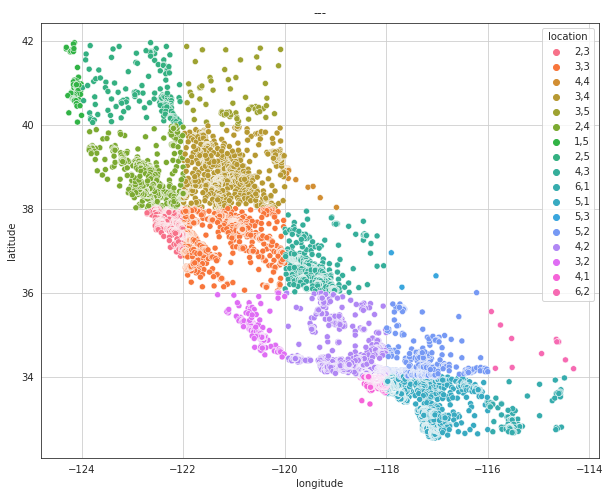

In [134]:
palette= sns.color_palette("RdBu", 10)
sns.set_palette(palette)
sns.set_style("white")

plt.figure(figsize=[10,8])

plt.subplot(111)
sns.scatterplot(data=housing, hue="location", x='longitude', y='latitude')
plt.grid()
plt.title("---")

plt.show()

## 3. Catégories, variables indicatrices et pipeline


In [29]:
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

num_attribs = ["total_rooms", "total_bedrooms", "households", "median_income"]
cat_attribs = ["location"]

num_pipeline = Pipeline([
        ('std_scaler', StandardScaler()),
    ])

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

In [57]:
# On redéfinit strat train et strat test et strat valid avec les nouvelles colonnes long disc...location

from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1,
                               test_size=0.2)

for train_index, test_index in split.split(housing, housing["median_house_value_disc"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

print(strat_train_set.shape)
print(strat_test_set.shape)

(14703, 15)
(3676, 15)


In [58]:
X_train = full_pipeline.fit_transform(strat_train_set)
y_train = np.array(strat_train_set["median_house_value"])

X_test = full_pipeline.fit_transform(strat_test_set)
y_test = np.array(strat_test_set["median_house_value"])

model = SGDRegressor(max_iter=1000, alpha=0.5)

model.fit(X_train, y_train)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape,"\n")

for i in range(X_train.shape[1]) :
    print(X_train[0,i])
print("\n")
for i in range(X_test.shape[1]) :
    print(X_test[0,i])

(14703, 21)
(14703,)
(3676, 21)
(3676,) 

0.3484348366223905
-0.28429197160904884
-0.2079317674579923
2.467521423861913
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


-0.278640764180459
-0.35063827189992175
-0.447175096801693
0.9896453162372465
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [59]:
metric = {'modele': 'model ',
          'mean_absolute_error': mean_absolute_error(y_test, model.predict(X_test)),
          'mean_squared_error': mean_squared_error(y_test, model.predict(X_test)),
          'r2_score':r2_score(y_test, model.predict(X_test))
         }

metric["r2_score"]

0.42449262967406853